In [1]:
# Libraries imports
import numpy as np
import matplotlib.pyplot as plt
import cv2, skimage, os, sys

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Local imports
from src import saliancy_map as sm
from src import utils
from src import optimization as opt
from src import database as db
from manippulating_saliency_main import phi, update_taus

print('Model loaded.')

96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864
96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864
Model loaded.


# Initialisation

In [3]:
# User Input
image_path = './data/debug/easy_apple_small.jpg'
mask_path = './data/debug/easy_apple_small_mask.jpg'
delta_s = 0.1

# Constants
EPSILON = 1e-3

# Modular Definitions
compute_saliency_map = sm.tempsal_saliency
minimize_J = opt.minimize_J_global_poisson
compute_database = db.compute_location_database


Image size: (447, 700, 3)


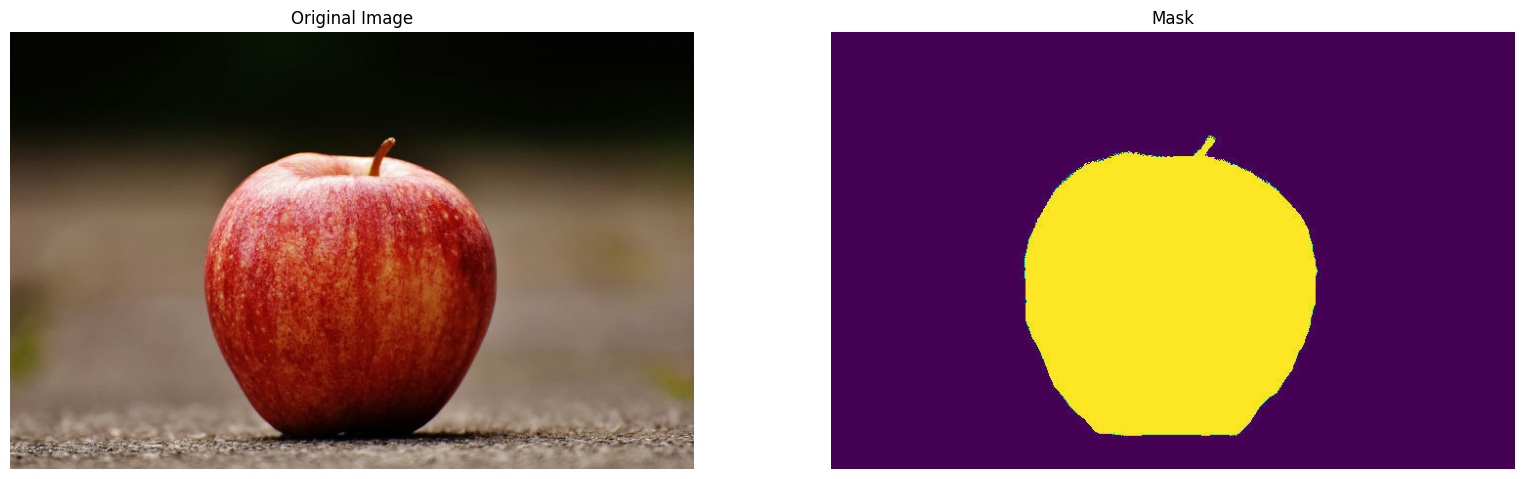

In [4]:
# Read the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Image size:", img.shape)

mask_image = cv2.imread(mask_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)[:,:]


utils.display_images([img, mask_image], titles=['Original Image', 'Mask'])

# Saliency Manipulation

In [5]:
# Initialize tau +/-
tau_positive = 0
tau_negative = 1
prev_tau_positive = tau_positive
prev_tau_negative = tau_negative
patch_size = 7

nb_iterations = 1

J_in = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
J_out = np.array([])

#### Partial Algorithm

You must do the iteration yourself :) 

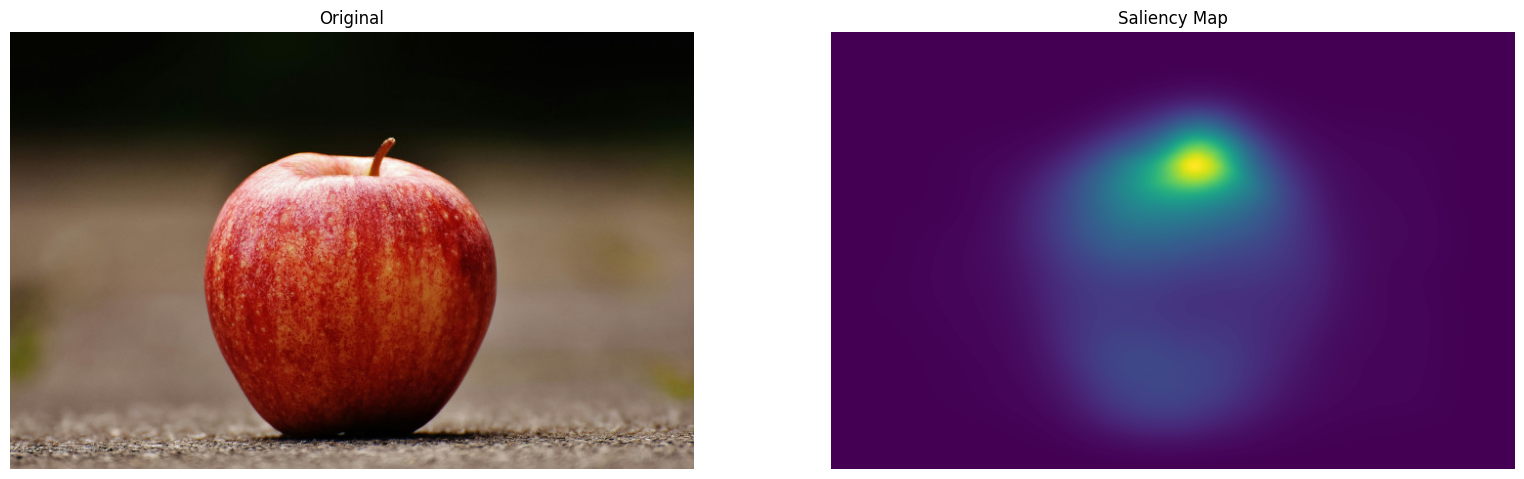

In [6]:
# Compute Saliency
s_map = compute_saliency_map(J_in)

utils.display_images([img, s_map], ['Original', 'Saliency Map'])

DB+ size: 312900, DB- size: 312899


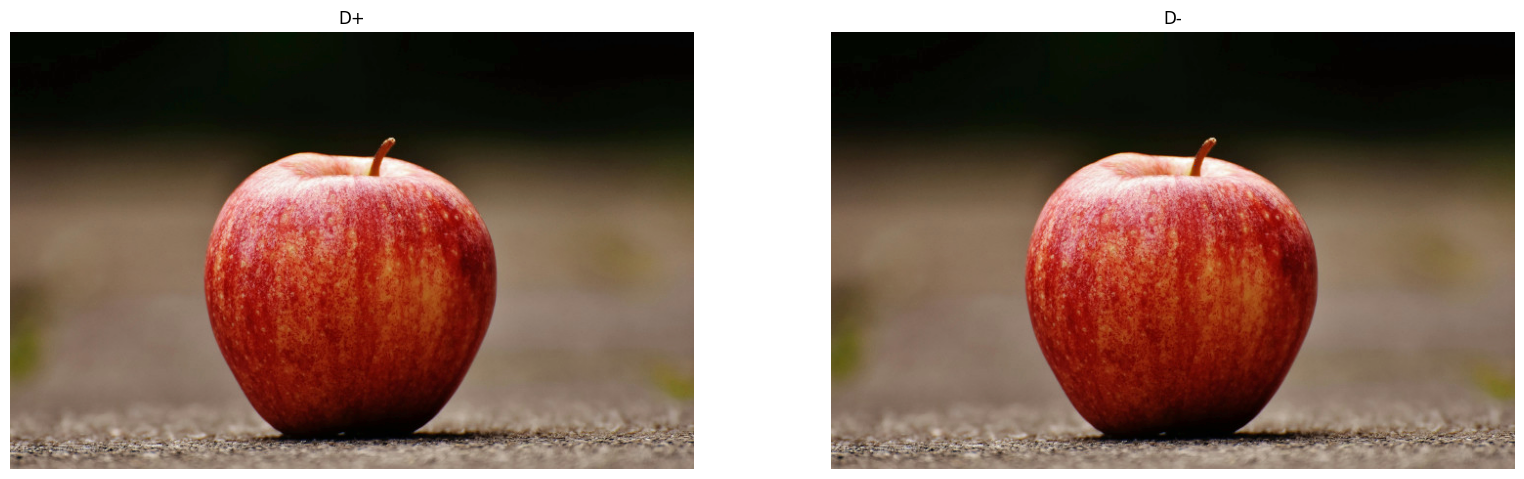

In [7]:
# DB update
D_positive, D_negative = compute_database(tau_positive, tau_negative, J_in, s_map)
print(f"DB+ size: {D_positive.shape[0]}, DB- size: {D_negative.shape[0]}")

# Construct and display the database's images
I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)

utils.display_images([I_D_positive, I_D_negative], ['D+', 'D-'])

Patch Match

In [22]:
width, height, _ = J_in.shape
radius = patch_size // 2
stride = patch_size

# Pad the image so that the patch don't overlap. (dont look, just know it works)
J_paded = np.stack([np.pad(J_in.astype(np.float64)[:,:,i], radius, mode="reflect") for i in range(3)]).transpose(1,2,0)
J_patched_paded = np.zeros_like(J_paded)

# Loop through all upper-left corners of each patch
for x in range(0, width - radius-1, stride):
    for y in range(0, height - radius-1, stride):
        off_x = x + radius
        off_y = y + radius
        patch = J_paded[off_x:off_x+patch_size, off_y:off_y+patch_size]
        mask_patch = mask_image[x:x+patch_size, y:y+patch_size]

        if mask_image[x + radius, y + radius] > 0 and len(D_positive) > 0:
            # Inside the mask (more salient)
            best_match = opt.find_best_match(patch, D_positive, J_paded)
            # best_match *= (mask_patch > 0)[:,:,None]               # keep only best match inside the mask
            # best_match += patch * (mask_patch == 0)[:,:,None]      # add back the original image outside the mask

        elif len(D_negative) > 0:
            # Outside the mask (less salient)
            best_match = opt.find_best_match(patch, D_negative, J_paded)
            # best_match *= (mask_patch == 0)[:,:,None]           # keep only best match outside the mask
            # best_match += patch * (mask_patch > 0)[:,:,None]    # add back the original image inside the mask
        else:
            best_match = patch  # If DB is empty keep orignal patch
        
        
        J_patched_paded[off_x:off_x+patch_size, off_y:off_y+patch_size] = best_match  # Replace patch

J_patched = J_patched_paded[radius:radius+width, radius:height+radius]

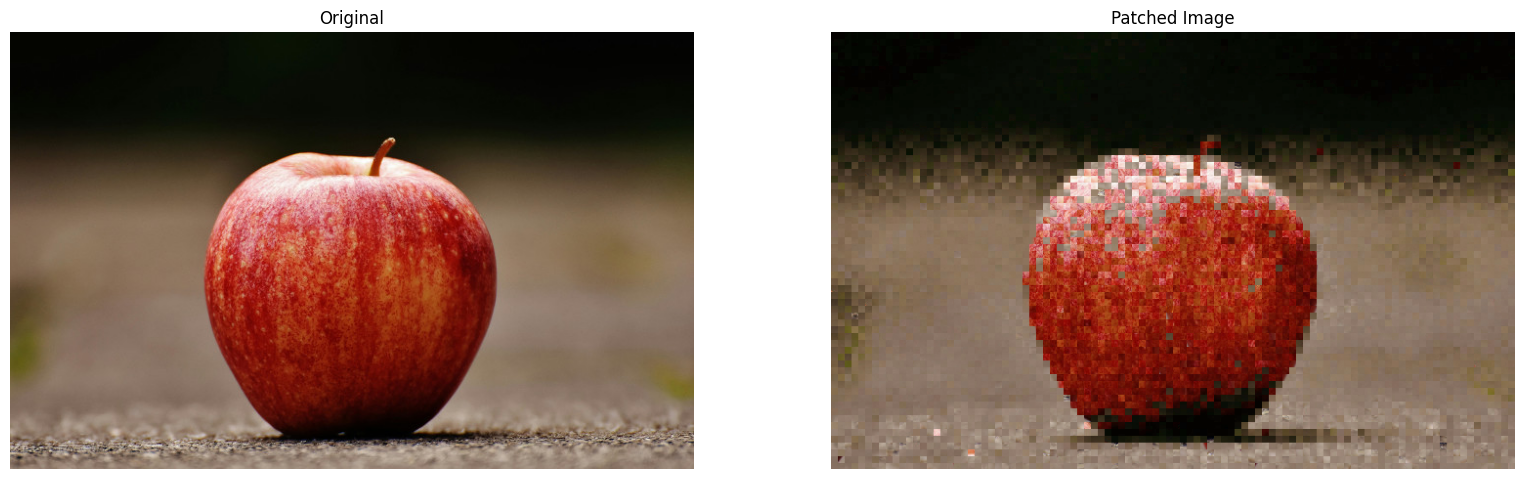

In [23]:
# Display patchMatch
J_patched_rgb = cv2.cvtColor(np.floor(J_patched).astype(np.uint8), cv2.COLOR_Lab2RGB)
utils.display_images([img, J_patched_rgb], ['Original', 'Patched Image'])

Poisson Screening

In [30]:
J_patched_padded = np.stack([np.pad(J_patched[:,:,i], radius, mode="reflect") for i in range(3)]).transpose(1,2,0)
poisson_padded = opt.screen_poisson(J_paded, J_patched_padded, lambda_factor=5)

# un-pad the image
J_out = np.floor(poisson_padded[radius:radius+width, radius:height+radius]).astype(np.uint8)

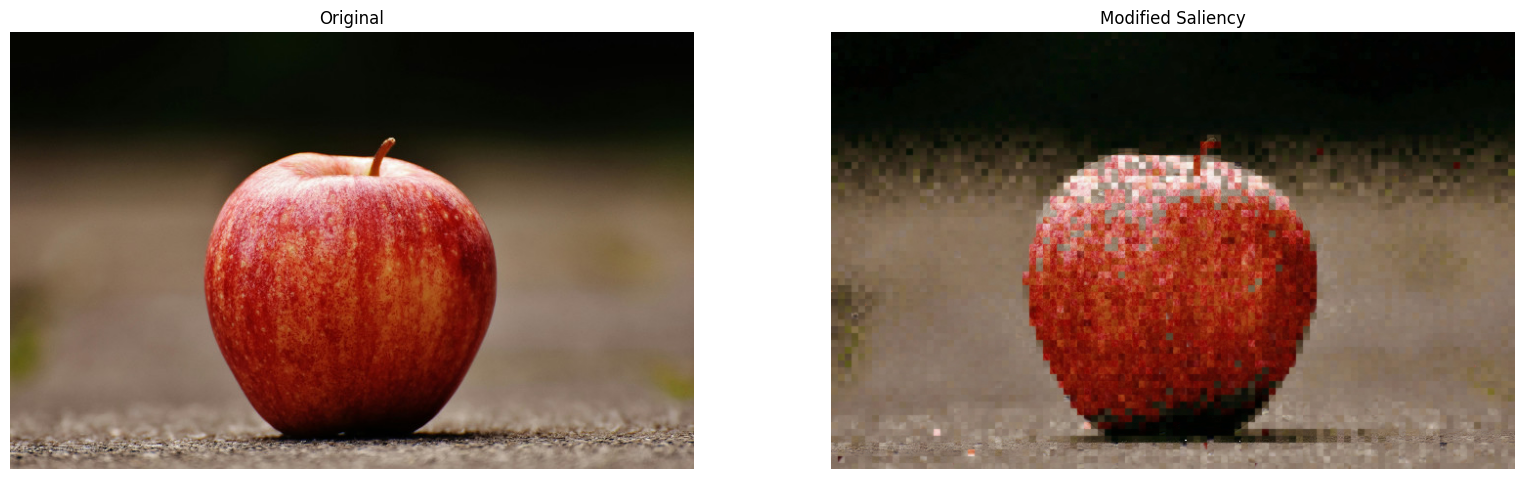

In [31]:
# Display Poisson Screen
J_out_rgb = cv2.cvtColor(J_out, cv2.COLOR_Lab2RGB)
utils.display_images([img, J_out_rgb], ['Original', 'Modified Saliency'])


##### Poisson lambda factor test

In [37]:
poissons = []
lambdas = np.logspace(-5,0, 6) * 5

J_patched_padded = np.stack([np.pad(J_patched[:,:,i], radius, mode="reflect") for i in range(3)]).transpose(1,2,0)
for l in lambdas:
    poisson_padded = opt.screen_poisson(J_paded, J_patched_padded, lambda_factor=l)

    # un-pad the image
    poissons.append(np.floor(poisson_padded[radius:radius+width, radius:height+radius]).astype(np.uint8))


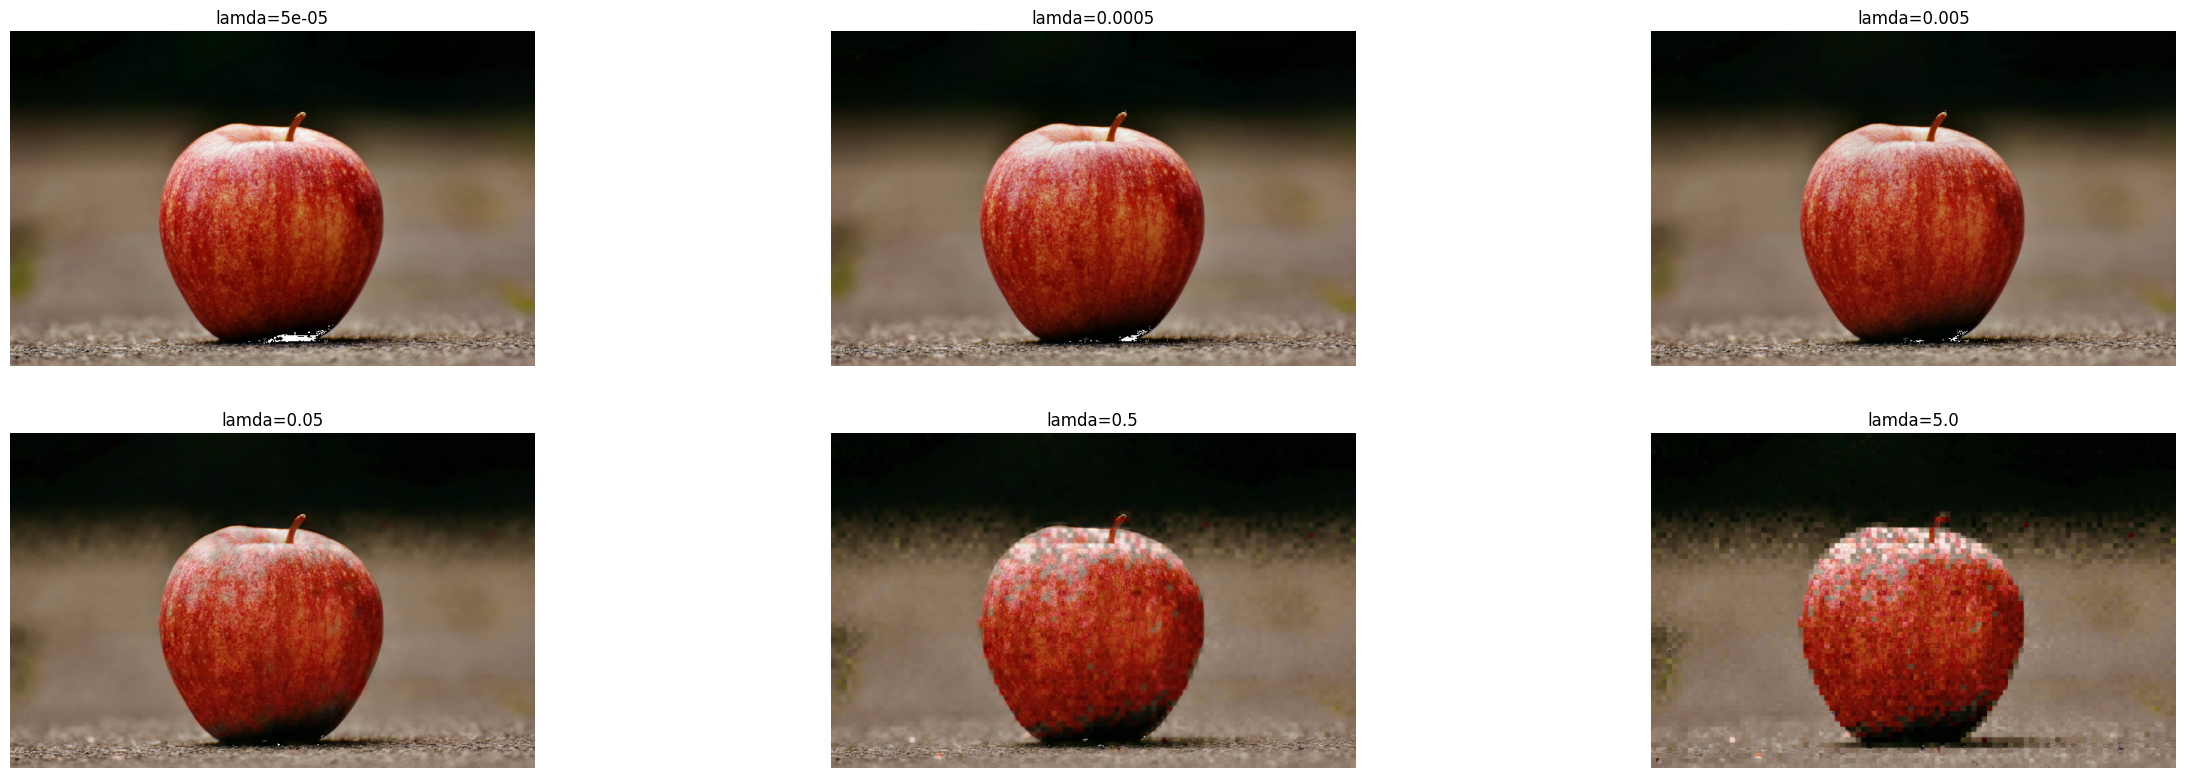

In [38]:
# Display results
utils.display_images([cv2.cvtColor(p, cv2.COLOR_Lab2RGB) for p in poissons], [f'lamda={l}' for l in lambdas])

(un-comment if you want to manualy iterate)

In [ ]:
# # switch the buffers
# temp = J_in.copy()
# J_in = J_out
# J_out = J_in

# # Update tau +/-
# tau_positive, tau_negative = update_taus(tau_positive, tau_negative, s_map, mask_image, delta_s)
# print(f'\n4Tau+: {tau_positive}, Tau-: {tau_negative}')


#### Full Algorithm

In [110]:
print("Begin Saliency Manipulation:")

# while compute_criterion(S_J, R, delta_s) > EPSILON:
for i in  range(nb_iterations):
    print(f"Iteration {i}")
    # update the saliency map
    print(" - computing Saliency...")
    s_map = compute_saliency_map(J_in)
    print(" - Done.")

    # DB update
    print(" - computing DB...")
    D_positive, D_negative = compute_database(tau_positive, tau_negative, J_in, s_map)
    print(f" - Done, DB+ size: {D_positive.shape[0]}, DB- size: {D_negative.shape[0]}")
    
    # Construct and display the database's images
    I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)

    # utils.display_images([S_J, I_D_positive, I_D_negative])

    # update J to minimize the energy function
    print(" - Minimizing function...")
    J_out = minimize_J(J_in.astype(np.float64), mask_image, D_positive, D_negative)
    print(" - Done.")
    # Update tau +/-
    tau_positive, tau_negative = update_taus(tau_positive, tau_negative, s_map, mask_image, delta_s)

    # switch the buffers (only affect the references so no copy is made)
    temp = J_in.copy()
    J_in = J_out
    J_out = J_in

    # Check if convergence is reached by tau's
    tau_diff = abs(tau_positive - prev_tau_positive) + abs(tau_negative - prev_tau_negative)
    prev_tau_positive, prev_tau_negative = tau_positive, tau_negative
    if tau_diff < EPSILON:
        break

    # print("\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K", end="")
    
# Cancel the last input-output exchange
temp = J_in.copy()
J_in = J_out
J_out = J_in

print("Done")
J_out = cv2.cvtColor(J_out, cv2.COLOR_Lab2RGB)

Begin Saliency Manipulation:
Iteration 0
 - computing Saliency...
 - Done.
 - computing DB...
 - Done, DB+ size: 184004, DB- size: 312697
 - Minimizing function...
  - Applying PatchMatch...
  - Applying Poisson Screening... - Done.
Done


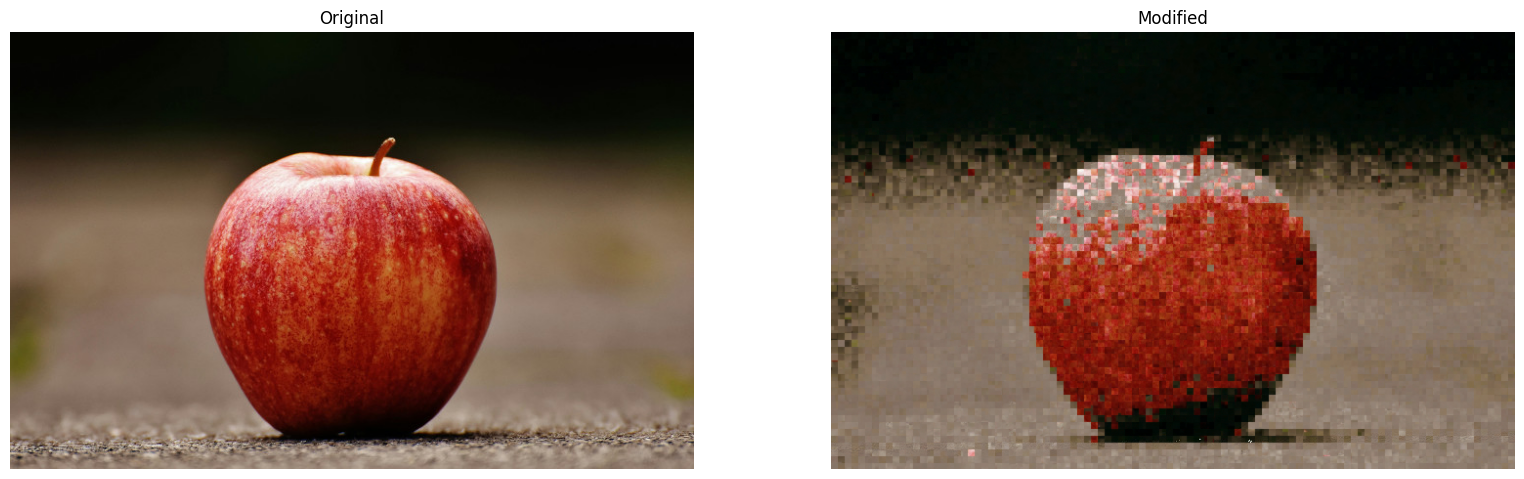

In [113]:
# Display results
utils.display_images([img, J_out], ['Original', 'Modified'])